# 🧠 Retail Stock Analysis — Cleaned & Model-Ready

This notebook is made for learning and sharing on Upwork.
It shows how to clean, analyze, and build a simple model
using retail stock data.

In [1]:
# Importing Important Libraries 

# Data handling and numerical computation
import pandas as pd
import numpy as np
import os

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Machine Learning tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ignore unnecessary warnings to keep output clean
import warnings
warnings.filterwarnings('ignore')

# These settings make sure our data shows properly when printed.
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)
print('Imports ready')

Imports ready


In [2]:

# Load the Dataset
df = pd.read_csv(r'C:\Users\AB-TECH\Sales analysis\Sale Report.csv')
print("First 5 rows of the dataset: ")
print(df.head())


# Basic Overview of the Data
print("Original shape:", df.shape)
print("Original columns:", list(df.columns))

print("\nDataset info:")
print(df.info())

print("\nSummary statistics:")
print(df.describe())

# Checking for Missing Values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Checking for Duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Data Types of Each Column
print("\nData types:")
print(df.dtypes)

# Unique Values in Categorical Columns
print("\nUnique values in categorical columns:")
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].nunique()} unique values")

First 5 rows of the dataset: 
   index       SKU Code Design No.  Stock       Category Size Color
0      0    AN201-RED-L      AN201    5.0  AN : LEGGINGS    L   Red
1      1    AN201-RED-M      AN201    5.0  AN : LEGGINGS    M   Red
2      2    AN201-RED-S      AN201    3.0  AN : LEGGINGS    S   Red
3      3   AN201-RED-XL      AN201    6.0  AN : LEGGINGS   XL   Red
4      4  AN201-RED-XXL      AN201    3.0  AN : LEGGINGS  XXL   Red
Original shape: (9271, 7)
Original columns: ['index', 'SKU Code', 'Design No.', 'Stock', 'Category', 'Size', 'Color']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9271 entries, 0 to 9270
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       9271 non-null   int64  
 1   SKU Code    9188 non-null   object 
 2   Design No.  9235 non-null   object 
 3   Stock       9235 non-null   float64
 4   Category    9226 non-null   object 
 5   Size        9235 non-null   obj

In [3]:
# Ensure deterministic index to avoid alignment issues
df = df.reset_index(drop=True)

In [4]:

# Cleaning: standardize text columns
text_cols = ['SKU Code', 'Design No.', 'Category', 'Size', 'Color']
for c in text_cols:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().replace({'nan': np.nan, 'None': np.nan, 'none': np.nan})


# Parse 'SKU Code' into Separate Parts
def parse_sku(sku):
    if pd.isna(sku):
        # Return empty values if SKU is missing
        return pd.Series([pd.NA, pd.NA, pd.NA], index=['sku_design','sku_color','sku_size'])
    
    # Split the SKU using '-' as a separator
    parts = str(sku).strip().split('-')

    if len(parts) >= 3:
        design = parts[0]
        size = parts[-1]
        color = '-'.join(parts[1:-1])
    elif len(parts) == 2:
        design = parts[0]; color = pd.NA; size = parts[1]
    else:
        design = parts[0]; color = pd.NA; size = pd.NA
    return pd.Series([design, color, size], index=['sku_design','sku_color','sku_size'])

# Apply the function to create new columns
if 'SKU Code' in df.columns:
    sku_parsed = df['SKU Code'].apply(parse_sku)
    df = pd.concat([df, sku_parsed], axis=1)
    print('Parsed SKU columns added: ', ['sku_design','sku_color','sku_size'])
df[['SKU Code','Design No.','sku_design','sku_color','sku_size']].head()


Parsed SKU columns added:  ['sku_design', 'sku_color', 'sku_size']


,SKU Code,Design No.,sku_design,sku_color,sku_size
0,AN201-RED-L,AN201,AN201,RED,L
1,AN201-RED-M,AN201,AN201,RED,M
2,AN201-RED-S,AN201,AN201,RED,S
3,AN201-RED-XL,AN201,AN201,RED,XL
4,AN201-RED-XXL,AN201,AN201,RED,XXL


In [5]:
# Fill Missing Values Using SKU and Design Logic
'''In this step, we’ll fix missing values in important columns like
Design No., Color, and Size by using information from the SKU
or by filling based on the most common (mode) values within each design.'''

# Fill missing Design/Color/Size using parsed SKU parts
'''Example: If 'Color' is missing but 'sku_color' is available, use it.'''

for target, src in [('Design No.', 'sku_design'), ('Color', 'sku_color'), ('Size', 'sku_size')]:
    if target in df.columns and src in df.columns:
        # Create a mask where target is missing but source is available
        mask = df[target].isna() & df[src].notna()
        # Fill missing target values with corresponding SKU info
        df.loc[mask, target] = df.loc[mask, src]

# Fill missing Category/Color/Size by most common value (mode) per Design
'''This step uses the "Design No." column as a key.
If multiple rows share the same design, we assume they belong to the same category, color, or size.'''

if 'Design No.' in df.columns:
    for col in ['Category', 'Color', 'Size']:
        if col in df.columns:
            # Build a mapping of each design to its most frequent (mode) value for this column
            mode_map = (
                df.loc[df[col].notnull()]
                .groupby('Design No.')[col]
                .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
                .to_dict()
            )
            
            # Create a mask for missing values in this column
            mask = df[col].isnull() & df['Design No.'].notnull()
            # Fill missing entries based on mode of the same design
            df.loc[mask, col] = df.loc[mask, 'Design No.'].map(mode_map)

# Replace any remaining missing values with "Unknown"
''' After all intelligent fills, any leftover missing data is labeled as 'Unknown'.'''

for c in ['Design No.', 'Category', 'Color', 'Size']:
    if c in df.columns:
        df[c] = df[c].fillna('Unknown')

# Display remaining missing values count
print("📊 Missing values after all fills:")
print(df[['Design No.', 'Category', 'Color', 'Size']].isnull().sum())


📊 Missing values after all fills:
Design No.    0
Category      0
Color         0
Size          0
dtype: int64


In [6]:
#Fill Missing Values in Numerical Columns (Using Median)

df['Stock'] = df['Stock'].fillna(df['Stock'].median())

In [7]:
# Drop Temporary SKU Helper Columns

'''The columns 'sku_design', 'sku_color', and 'sku_size' were only created 
for cleaning and filling missing values. 
Now that the data is ready, we remove these helper columns 
to keep the dataset neat and modeling-ready.'''

for c in ['sku_design', 'sku_color', 'sku_size']:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

print("Temporary SKU columns dropped successfully.")

Temporary SKU columns dropped successfully.


In [8]:
# --- Step 3: Identify Numeric Columns ---
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
print("Numeric Columns Found:", numeric_cols)


Numeric Columns Found: ['index', 'Stock']


In [9]:
# Drop index feature if exists
index = 'index'
if index in df.columns:
    df.drop(columns=[index], inplace=True)
    print(f"Index column '{index}' dropped successfully.")
print("Numeric Columns Found:", numeric_cols)


Index column 'index' dropped successfully.
Numeric Columns Found: ['index', 'Stock']


In [10]:
import plotly.express as px
import pandas as pd

# Step 1: Aggregate and sort top 10 designs
top_designs = df.groupby('Design No.')['Stock'].sum().reset_index()
top_designs = top_designs.sort_values(by='Stock', ascending=False).head(10)

# Step 2: Calculate percentage contribution
top_designs['Percentage'] = (top_designs['Stock'] / top_designs['Stock'].sum() * 100).round(2)

# Step 3: Create bar chart with smart color
fig2 = px.bar(
    top_designs,
    x='Design No.',
    y='Stock',
    title=" Top 10 Best Stocked Designs",
    color='Stock',
    color_continuous_scale=px.colors.sequential.Teal,  # attractive gradient
    text='Stock',  # show numbers on bars
    hover_data=['Stock', 'Percentage']
)

# Step 4: Sort bars descending
fig2.update_layout(
    xaxis={'categoryorder':'total descending'},  # ensures bars sorted by Stock
    width=1000,
    height=700,
    template='plotly_white',
    title_font=dict(size=24, family='Arial', color='black'),
    xaxis_title="Design No",
    yaxis_title="Stock",
    uniformtext_minsize=12,
    uniformtext_mode='show',  # ensures numbers are visible
    coloraxis_colorbar=dict(
        title="Stock Level",
        tickprefix="",
        thickness=20
    )
)

# Step 5: Show figure
fig2.show()


In [11]:
fig4 = px.box(
    df,
    x='Category',
    y='Stock',
    color='Category',
    title="📦 Stock Distribution by Category",
    color_discrete_sequence=px.colors.qualitative.Prism
)

fig4.update_layout(
    width=1000,
    height=750,
    template='plotly_dark',
    title_font=dict(size=22),
    xaxis_title="Category",
    yaxis_title="Stock Level"
)
fig4.show()


In [12]:
#Fill Missing Values in Numerical Columns (Using Median)

df['Stock'] = df['Stock'].fillna(df['Stock'].median())

In [13]:
# Normalize Text Formats for Category, Color, and Size

'''This step ensures consistency across text-based columns.
It removes unwanted spaces, symbols, and converts text to a standard format.
Example: "blue ", " BLUE", and "Blue" will all become "Blue".'''

# Clean and standardize 'Category'
if 'Category' in df.columns:
    # Remove prefixes like "Category:" and fix capitalization
    df['Category'] = (
        df['Category']
        .astype(str)
        .str.replace(r'^\w+\s*:\s*', '', regex=True)
        .str.strip()
        .str.title()
    )

# Clean and standardize 'Color'
if 'Color' in df.columns:
    # Trim spaces and standardize case
    df['Color'] = df['Color'].astype(str).str.strip().str.title()

# Clean and standardize 'Size'
if 'Size' in df.columns:
    # Convert to uppercase and unify similar labels (e.g., OS → FREE SIZE)
    df['Size'] = (
        df['Size']
        .astype(str)
        .str.strip()
        .str.upper()
        .replace({'ONE SIZE': 'FREE SIZE', 'OS': 'FREE SIZE', 'FREE': 'FREE SIZE'})
    )

# Show a quick preview of standardized values
print("📊 Sample unique values after normalization:")
print("Categories:", df['Category'].dropna().unique()[:20])
print("Colors    :", df['Color'].dropna().unique()[:20])
print("Sizes     :", df['Size'].dropna().unique()[:20])


📊 Sample unique values after normalization:
Categories: ['Leggings' 'Blouse' 'Pant' 'Bottom' 'Palazzo' 'Sharara' 'Skirt' 'Dress'
 'Kurta Set' 'Lehenga Choli' 'Set' 'Top' 'Kurta' 'Unknown' 'Crop Top'
 'Tunic' 'Cardigan' 'Jumpsuit' 'Crop Top With Plazzo' 'Saree']
Colors    : ['Red' 'Orange' 'Maroon' 'Purple' 'Yellow' 'Green' 'Pink' 'Beige'
 'Navy Blue' 'Black' 'White' 'Brown' 'Gold' 'Chiku' 'Blue' 'Multicolor'
 'Peach' 'Grey' 'Olive' 'Dark Green']
Sizes     : ['L' 'M' 'S' 'XL' 'XXL' 'FREE SIZE' 'XS' 'XXXL' '4XL' '5XL' '6XL'
 'UNKNOWN']


In [14]:
import plotly.express as px
import pandas as pd

# Step 1: Aggregate stock by size
stock_by_size = df.groupby('Size')['Stock'].sum().reset_index()

# Step 2: Sort by stock descending
stock_by_size = stock_by_size.sort_values(by='Stock', ascending=False)

# Step 3: Create the bar chart
fig4 = px.bar(
    stock_by_size,
    x='Size',
    y='Stock',
    color='Size',
    title='📏 Stock Distribution by Size (Highest to Lowest)',
    color_discrete_sequence=px.colors.qualitative.Bold,
    text='Stock',  # display values on bars
    hover_data={'Stock': True, 'Size': True}  # customize hover info
)

# Step 4: Customize layout
fig4.update_layout(
    width=1000,
    height=700,
    template='plotly_white',
    title_font=dict(size=22, family='Arial', color='black'),
    xaxis_title="Size",
    yaxis_title="Total Stock",
    uniformtext_minsize=12,
    uniformtext_mode='hide'
)

# Step 5: Show figure
fig4.show()



In [15]:
# Pie chart for Size distribution

fig2 = px.pie(
    df,
    names='Size',
    title="📏 Size Distribution",
    color_discrete_sequence=px.colors.qualitative.Vivid
)
fig2.update_layout(
    width=1000,
    height=700,
    title_x=0.5,
    font=dict(size=16)
)
fig2.show()

In [16]:

# Standardize & Group Similar Color Names

'''This step makes color names consistent and business-friendly.
For example: “Light-Green”, “Olive-Green”, and “Mint-Green” 
will all be grouped under the main color “Green”.'''

# Define color grouping dictionary
color_map = {
    # Greens
    'Light-Green': 'Green', 'Lime-Green': 'Green', 'Olive-Green': 'Green',
    'Dark-Green': 'Green', 'Mint-Green': 'Green', 'Aqua-Green': 'Green', 
    'Sea-Green': 'Green', 'Teal-Green': 'Green',

    # Blues
    'Turquoise-Green': 'Blue', 'Light-Blue': 'Blue', 'Navy-Blue': 'Blue',
    'Dark-Blue': 'Blue', 'Sky-Blue': 'Blue', 'Powder-Blue': 'Blue',
    'Turquoise-Blue': 'Blue', 'Teal-Blue': 'Blue', 'Indigo': 'Blue',
    'Turquoise': 'Blue', 'Navy': 'Blue',

    # Whites
    'Off-White': 'White', 'Cream': 'White', 'White': 'White',

    # Grays / Blacks
    'Grey': 'Gray', 'Charcoal': 'Gray', 'Black': 'Black',

    # Browns / Beiges
    'Beige': 'Beige', 'Taupe': 'Brown', 'Khaki': 'Brown', 'Brown': 'Brown',
    'Light-Brown': 'Brown', 'Chiku': 'Brown',

    # Reds
    'Red': 'Red', 'Maroon': 'Red', 'Burgundy': 'Red', 'Wine': 'Red',

    # Pinks
    'Pink': 'Pink', 'Light-Pink': 'Pink', 'Magenta': 'Pink',
    'Peach': 'Pink', 'Coral-Pink': 'Pink',

    # Oranges
    'Coral': 'Orange', 'Coral-Orange': 'Orange', 'Rust': 'Orange', 'Orange': 'Orange',

    # Yellows
    'Mustard': 'Yellow', 'Lemon': 'Yellow', 'Gold': 'Yellow', 'Light-Yellow': 'Yellow',

    # Purples
    'Purple': 'Purple', 'Mauve': 'Purple',

    # Misc
    'Multicolor': 'Multicolor', 'No Reference': 'Unknown', 'Unknown': 'Unknown'
}

# Clean and map colors
if 'Color' in df.columns:
    # Replace spaces/underscores with hyphens for uniformity
    df['Color_clean'] = (
        df['Color']
        .astype(str)
        .str.strip()
        .str.replace(r'[\s_]+', '-', regex=True)
        .map(lambda x: color_map.get(x.title(), x.title()))
    )

    # Fill any unmapped colors as 'Unknown'
    df['Color_clean'] = df['Color_clean'].fillna('Unknown')

# --- Display a quick preview
print("Color mapping completed. Sample unique values:")
print(df['Color_clean'].unique()[:20])


Color mapping completed. Sample unique values:
['Red' 'Orange' 'Purple' 'Yellow' 'Green' 'Pink' 'Beige' 'Blue' 'Black'
 'White' 'Brown' 'Multicolor' 'Gray' 'Olive' 'Teal' 'Lemon-Yellow'
 'Unknown' 'Mint' 'No-Reference']


In [17]:
import plotly.express as px
import pandas as pd

# Step 1: Clean colors
df['Color'] = df['Color'].str.strip().str.title()

# Step 2: Aggregate top 10 colors
color_data = df.groupby('Color')['Stock'].sum().reset_index()
color_data = color_data.sort_values(by='Stock', ascending=False).head(10)

# Step 3: Calculate percentage
color_data['Percentage'] = (color_data['Stock'] / color_data['Stock'].sum() * 100).round(2)

# Step 4: Define exact color mapping
color_map = {
    'Blue': "#0c91f1",
    'Green': "#27b727",
    'Pink': '#e377c2',
    'Black': '#000000',
    'Teal': "#05A9A9",
    'Maroon': "#9F0909",
    'Navy-Blue': "#04044B",
    'Peach': "#FF9D48",
    'Mustard': "#EBBD18",
    'Light-Green': "#83DB83"
}

# Step 5: Create pie chart
fig3 = px.pie(
    color_data,
    names='Color',
    values='Stock',
    title='🎨 Top 10 Colors by Stock',
    color='Color',
    color_discrete_map=color_map,
    hover_name='Color',  # hover will show the color name
    hover_data=['Stock', 'Percentage']  # pass as list, not dict
)

# Step 6: Highlight top color
fig3.update_traces(
    textinfo='percent+label',
    pull=[0.1 if i==0 else 0 for i in range(len(color_data))],
    marker=dict(line=dict(color='black', width=1))
)

# Step 7: Layout adjustments
fig3.update_layout(
    width=900,
    height=700,
    title_font=dict(size=22, family='Arial', color='black'),
    legend_title_text="Color"
)

fig3.show()


In [18]:

# Category Cleaning & Grouping for Modeling

'''In this step, we make product categories consistent and business-ready.
We correct spelling issues, standardize formats, and group similar items 
into broader, model-friendly segments (e.g., “Kurti” and “Kurta-Set” → “Ethnic-Topwear”).'''

# Fix spelling errors and inconsistent names
cat_corr = {
    'Kurta': 'Kurti',
    'Kurta-Set': 'Kurta-Set',
    'Kurti ': 'Kurti',
    'An : Leggings': 'Leggings',
    'Crop Top With Plazzo': 'Crop-Top With Palazzo',
    'Night Wear': 'Night-Wear'
}

df['Category_clean'] = (
    df['Category']
    .replace(cat_corr)
    .astype(str)
    .str.strip()
    .str.title()
)

# Group similar categories into major segments
group_map = {
    # Ethnic topwear
    'Kurti': 'Ethnic-Topwear', 'Kurta-Set': 'Ethnic-Topwear',
    
    # Ethnic dresswear
    'Lehenga-Choli': 'Ethnic-Dresswear', 'Saree': 'Ethnic-Dresswear',
    'Dress': 'Ethnic-Dresswear', 'Night-Wear': 'Ethnic-Dresswear', 'Set': 'Ethnic-Dresswear',
    
    # Bottomwear
    'Pant': 'Bottomwear', 'Palazzo': 'Bottomwear', 'Sharara': 'Bottomwear',
    'Skirt': 'Bottomwear', 'Leggings': 'Bottomwear', 'Bottom': 'Bottomwear',
    
    # Western topwear
    'Top': 'Western-Topwear', 'Crop-Top': 'Western-Topwear', 'Tunic': 'Western-Topwear',
    'Blouse': 'Western-Topwear', 'Cardigan': 'Western-Topwear', 'Jumpsuit': 'Western-Topwear'
}

df['Category_group'] = (
    df['Category_clean']
    .map(group_map)
    .fillna('Other')  # Fallback for ungrouped categories
)

# Quick check
print("Category grouping complete.")
print("Unique Groups:", df['Category_group'].unique())


Category grouping complete.
Unique Groups: ['Bottomwear' 'Western-Topwear' 'Ethnic-Dresswear' 'Other'
 'Ethnic-Topwear']


In [19]:
import plotly.express as px
import pandas as pd

# Step 1: Aggregate and sort stock by category
category_stock = df.groupby('Category_group')['Stock'].sum().reset_index()
category_stock = category_stock.sort_values(by='Stock', ascending=False)

# Step 2: Calculate percentage contribution
category_stock['Percentage'] = (category_stock['Stock'] / category_stock['Stock'].sum() * 100).round(2)

# Step 3: Create bar chart with vibrant colors
fig1 = px.bar(
    category_stock,
    x='Category_group',
    y='Stock',
    title=" Total Stock by Category",
    text='Stock',
    color='Category_group',  # different color for each category
    color_discrete_sequence=px.colors.qualitative.Bold,  # vibrant colors
    hover_data=['Stock', 'Percentage']
)

# Step 4: Customize layout for dark background
fig1.update_traces(textposition='outside', textfont_color='white')  # text visible on dark bg
fig1.update_layout(
    xaxis={'categoryorder':'total descending'},
    width=1000,
    height=700,
    template='plotly_dark',  # dark background
    title_font=dict(size=24, family='Arial', color='white'),
    xaxis_title="Category",
    yaxis_title="Total Stock",
    uniformtext_minsize=12,
    uniformtext_mode='show',
    plot_bgcolor='#111111',  # optional extra dark
    paper_bgcolor='#111111',
    legend_title_text="Category"
)

fig1.show()


In [20]:
# Feature Engineering — Business Insights

'''In this step, we create new meaningful features to help models and analysis.
These features capture relationships between stock, categories, colors, and sizes.'''

# Calculate stock proportion per category
'''Shows how much each product contributes to its category’s total stock.'''
if 'Stock' in df.columns and 'Category_group' in df.columns:
    cat_totals = df.groupby('Category_group')['Stock'].sum()
    df['Stock_per_Category'] = df.apply(
        lambda r: r['Stock'] / cat_totals.get(r['Category_group'], 1),
        axis=1
    )

# Measure popularity of each color
'''Gives a normalized score (0–1) showing how frequent each color appears.'''
df['Color_Popularity'] = df['Color_clean'].map(
    df['Color_clean'].value_counts(normalize=True)
)

# Measure popularity of each size
'''Same logic as color — reflects how common each size is in the dataset.'''
df['Size_Popularity'] = df['Size'].map(
    df['Size'].value_counts(normalize=True)
)

# Preview new features
print(" Feature engineering complete: Added Stock_per_Category, Color_Popularity, and Size_Popularity.")
df[['Category_group', 'Stock', 'Stock_per_Category', 'Color_clean', 'Color_Popularity', 'Size', 'Size_Popularity']].head()


 Feature engineering complete: Added Stock_per_Category, Color_Popularity, and Size_Popularity.


,Category_group,Stock,Stock_per_Category,Color_clean,Color_Popularity,Size,Size_Popularity
0,Bottomwear,5.0,0.000712,Red,0.100097,L,0.143997
1,Bottomwear,5.0,0.000712,Red,0.100097,M,0.144752
2,Bottomwear,3.0,0.000427,Red,0.100097,S,0.145939
3,Bottomwear,6.0,0.000855,Red,0.100097,XL,0.144537
4,Bottomwear,3.0,0.000427,Red,0.100097,XXL,0.144321


In [21]:
# Encoding Categorical Features for Modeling

'''Machine learning models work best with numerical data.
Here, we convert categorical columns (like color, size, and category)
into numeric codes using Label Encoding.'''

# Initialize encoder dictionary
encoders = {}

# Encode selected categorical columns
for col in ['Design No.', 'Category_group', 'Color_clean', 'Size']:
    if col in df.columns:
        le = LabelEncoder()
        # Convert text → numeric labels
        df[col + '_enc'] = le.fit_transform(df[col].astype(str))
        encoders[col] = le  # Save encoder for later decoding if needed

# Verify new encoded columns
print("Encoding complete. Encoded columns created:")
print([c for c in df.columns if c.endswith('_enc')])

# Preview encoded data
df[[c for c in df.columns if c.endswith('_enc')]].head()


Encoding complete. Encoded columns created:
['Design No._enc', 'Category_group_enc', 'Color_clean_enc', 'Size_enc']


,Design No._enc,Category_group_enc,Color_clean_enc,Size_enc
0,0,0,14,4
1,0,0,14,5
2,0,0,14,6
3,0,0,14,8
4,0,0,14,10


In [22]:

# Prepare features and target for model training
'''Now that data cleaning and feature engineering are complete, 
we’ll select the columns (features) that will help our model 
understand stock patterns and predict outcomes.'''

# Define important feature columns
feature_cols = [
    'Design No._enc',          # Encoded design number
    'Category_group_enc',      # Encoded category group (like Ethnic, Western, etc.)
    'Color_clean_enc',         # Encoded clean color column
    'Size_enc',                # Encoded size column
    'Stock_per_Category',      # Feature showing stock proportion within each category
    'Color_Popularity',        # Normalized frequency of each color
    'Size_Popularity'          # Normalized frequency of each size
]

# Validate that all required columns exist
for c in feature_cols:
    if c not in df.columns:
        raise KeyError(f'Missing feature column: {c} — please run previous preprocessing cells.')

# Split dataset into features (X) and target variable (y)
X = df[feature_cols].copy()   # Independent variables for the model
y = df['Stock'].copy()        # Target variable — stock quantity

# Display dataset shapes for confirmation
print('X shape, y shape:', X.shape, y.shape)

# Preview top rows
X.head()



X shape, y shape: (9271, 7) (9271,)


,Design No._enc,Category_group_enc,Color_clean_enc,Size_enc,Stock_per_Category,Color_Popularity,Size_Popularity
0,0,0,14,4,0.000712,0.100097,0.143997
1,0,0,14,5,0.000712,0.100097,0.144752
2,0,0,14,6,0.000427,0.100097,0.145939
3,0,0,14,8,0.000855,0.100097,0.144537
4,0,0,14,10,0.000427,0.100097,0.144321


In [23]:

# Split data into training and testing sets
'''We’ll divide the dataset into training and testing parts 
so the model can learn from one portion and be evaluated on unseen data.'''

# Split features and target (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20,        # 20% data for testing
    random_state=42        # ensures consistent results on every run
)

# Display the shape of splits for confirmation
print('Train/test shapes:', X_train.shape, X_test.shape)


Train/test shapes: (7416, 7) (1855, 7)


In [ ]:
# Random Forest Regressor (Model Training + Evaluation)
'''We’ll train a Random Forest model to predict stock values.
This model is widely used for business forecasting because it handles
non-linear data and feature interactions effectively.'''

# Import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error, explained_variance_score
)
import pandas as pd

# Initialize and train model
rf = RandomForestRegressor(
    n_estimators=300,   # slightly higher trees for stable performance
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Step 4: Evaluation metrics
mae_rf  = mean_absolute_error(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5
r2_rf   = r2_score(y_test, y_pred_rf)
evs_rf  = explained_variance_score(y_test, y_pred_rf)

# Create a clean summary table
metrics_table = pd.DataFrame({
    'Metric': [
        'Mean Absolute Error (MAE)',
        'Mean Absolute Percentage Error (MAPE)',
        'Root Mean Squared Error (RMSE)',
        'R² Score',
        'Explained Variance Score'
    ],
    'Value': [
        round(mae_rf, 4),
        f"{mape_rf*100:.2f}%",
        round(rmse_rf, 4),
        round(r2_rf, 4),
        round(evs_rf, 4)
    ]
})

# Step 6: Display results
print("📊 Random Forest Regression Results")
print(metrics_table.to_string(index=False))


📊 Random Forest Regression Results
                               Metric   Value
            Mean Absolute Error (MAE)  0.6969
Mean Absolute Percentage Error (MAPE)   0.52%
       Root Mean Squared Error (RMSE)  8.7278
                             R² Score  0.9767
             Explained Variance Score  0.9768


In [31]:
import plotly.express as px
import pandas as pd

# Convert test and prediction values into a DataFrame for Plotly
df_plot = pd.DataFrame({
    'Actual Sales': y_test,
    'Predicted Sales': y_pred_rf
})

# Create scatter plot
fig = px.scatter(
    df_plot,
    x='Actual Sales',
    y='Predicted Sales',
    title='📊 Actual vs Predicted Sales (Random Forest Model)',
    trendline='ols',  # adds a regression line
    opacity=0.7,
    color_discrete_sequence=['#0074D9']
)

# Add reference line (y = x)
fig.add_shape(
    type='line',
    x0=df_plot['Actual Sales'].min(),
    y0=df_plot['Actual Sales'].min(),
    x1=df_plot['Actual Sales'].max(),
    y1=df_plot['Actual Sales'].max(),
    line=dict(color='red', dash='dash'),
    name='Ideal Fit'
)

# Update layout for a clean, professional look
fig.update_layout(
    title_font=dict(size=20, family='Arial', color='black'),
    xaxis_title='Actual Sales',
    yaxis_title='Predicted Sales',
    plot_bgcolor='white',
    hoverlabel=dict(bgcolor='white', font_size=13, font_family='Arial'),
    margin=dict(l=60, r=40, t=80, b=60),
    font=dict(family='Arial', size=14),
)

# Add gridlines
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')

fig.show()



In [ ]:

# Feature importance (RF)
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
print('Feature importances:')
display(feat_imp)
fig3 = px.bar(feat_imp, x='importance', y='feature', orientation='h', title='Feature Importance (Random Forest)', width=1000, height=600)
fig3.update_layout(template='plotly_white', yaxis={'categoryorder':'total ascending'})
fig3.show()


Feature importances:


,feature,importance
4,Stock_per_Category,0.650351
0,Design No._enc,0.170768
1,Category_group_enc,0.145135
2,Color_clean_enc,0.016159
3,Size_enc,0.007217
5,Color_Popularity,0.005760
6,Size_Popularity,0.004612


In [27]:
from sklearn.feature_selection import RFE

rfe = RFE(RandomForestRegressor(), n_features_to_select=5)
rfe.fit(X_train, y_train)
selected = X_train.columns[rfe.support_]
print("Selected features:", selected)


Selected features: Index(['Design No._enc', 'Category_group_enc', 'Color_clean_enc', 'Size_enc', 'Stock_per_Category'], dtype='object')


In [28]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("Average R²:", scores.mean())


Average R²: 0.22118314849077675


In [34]:
import pandas as pd

sample_data = pd.DataFrame({
    'Design No._enc': [12, 7, 15],
    'Category_group_enc': [3, 1, 2],
    'Color_clean_enc': [45, 20, 33],
    'Size_enc': [5, 8, 10],
    'Stock_per_Category': [0.034, 0.050, 0.042],
    'Color_Popularity': [0.48, 0.63, 0.59],
    'Size_Popularity': [0.97, 0.95, 0.99]
})


In [35]:
predicted_stock = rf.predict(sample_data)
print("Predicted Stock Values:", predicted_stock)


Predicted Stock Values: [516.48333333 463.50666667 560.15666667]


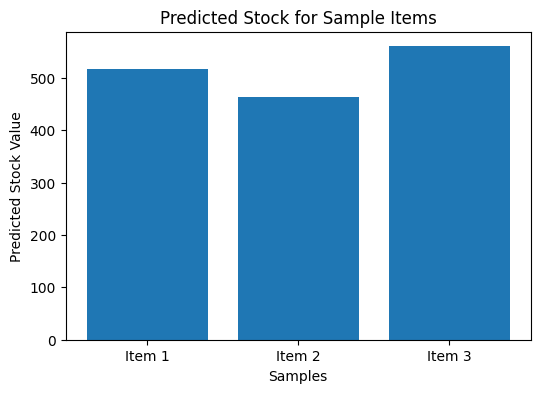

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(['Item 1', 'Item 2', 'Item 3'], predicted_stock)
plt.title("Predicted Stock for Sample Items")
plt.xlabel("Samples")
plt.ylabel("Predicted Stock Value")
plt.show()


In [33]:

import os
import joblib

# ✅ Set folder path (change this to your own local folder path)
save_folder = r"C:\Users\AB-TECH\Sales analysis"  # <-- change this to your real folder path

# Create folder if it doesn’t exist
os.makedirs(save_folder, exist_ok=True)

# ✅ Save cleaned dataset
cleaned_path = os.path.join(save_folder, "sale_report_cleaned_for_model.csv")
df.to_csv(cleaned_path, index=False)
print(f"✅ Cleaned dataset saved successfully at: {cleaned_path}")

# ✅ Save trained Random Forest model
model_path = os.path.join(save_folder, "rf_stock_model.joblib")
joblib.dump(rf, model_path)
print(f"✅ Random Forest model saved successfully at: {model_path}")


✅ Cleaned dataset saved successfully at: C:\Users\AB-TECH\Sales analysis\sale_report_cleaned_for_model.csv
✅ Random Forest model saved successfully at: C:\Users\AB-TECH\Sales analysis\rf_stock_model.joblib
